## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [46]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [47]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [48]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [49]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [50]:
df[df['converted'] == 1]['user_id'].count()/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [51]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [53]:
df2=df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index).reset_index(drop=True)

In [54]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [55]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [56]:
## Checking for the one duplicate row ##
df2.shape[0]-df2['user_id'].nunique()
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [57]:
## Choosing the older row to delete it ##
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [58]:
df2.shape[0]

290585

In [59]:
df2.drop(df2.index[1876], inplace=True)

In [60]:
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [61]:
df.converted.mean()

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [62]:
df.query('group == "control"')['converted'].mean()

0.12039917935897611

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [63]:
df.query('group == "treatment"')['converted'].mean()

0.11891957956489856

d. What is the probability that an individual received the new page?

In [64]:
df.query('landing_page == "new_page"')['user_id'].count()/df.shape[0]

0.5

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

### Pre-Conclusion ###
<font color='STEELBLUE'>
Considering results from point **c** and point **d**, the probability of being control and converting to the new page is 12% and the probability being in treatment and converting to the old page is also 11.88% close also to 12% .. so it's not sufficient yet to determine whether to convert to the new page or stay on the old page
</font>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

** $H_0 $ Null Hypothesis: ** The  new version is no better, or even worse, than the old version 

 $p_{new}$ - $p_{old} \leq 0$
 
** $H_1 $ Alternative Hypothesis: ** The new version is better than the old version 

$p_{new}$ - $p_{old} > 0$





`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [65]:
p_new = df2.query('converted == 1').user_id.count()/df2.user_id.count()
p_new 

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [66]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [67]:
n_new = df2.query('landing_page == "new_page"').user_id.count()
n_new

145310

d. What is $n_{old}$?

In [68]:
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [85]:
## Simulation of N_New ##
new_page_converted =  np.random.binomial(1,0.12,n_new)

In [86]:
## N_New mean ##
'''plt.hist(new_page_converted);'''
new_page_converted.mean()

0.1212235909435001

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [87]:
## Simulation of N_Old ##
old_page_converted =  np.random.binomial(1,0.12,n_old)

In [88]:
## N_Old mean ##
'''plt.hist(old_page_converted);'''
old_page_converted.mean()

0.11874802098104272

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [89]:
sim_diff = new_page_converted.mean() -  old_page_converted.mean()
sim_diff

0.0024755699624573885

In [90]:
## Observed Difference ##
control_proportion = df2.query('group=="control" & converted==1')['user_id'].count()/df2.query('group=="control"')['user_id'].count()
treatment_proportion = df2.query('group=="treatment" & converted==1')['user_id'].count()/df2.query('group=="treatment"')['user_id'].count()
obs_diff = treatment_proportion - control_proportion
obs_diff

-0.0015782389853555567

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [91]:
p_diffs = []
new_sim = np.random.binomial(n_new,p_new,10000)/n_new
old_sim = np.random.binomial(n_old,p_old,10000)/n_old

## append info ##
p_diffs = (new_sim - old_sim)
p_diffs = np.array(p_diffs)

In [92]:
np.percentile(p_diffs,2.5), np.percentile(p_diffs,97.5)

(-0.0023765172394193445, 0.0023310987137879504)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

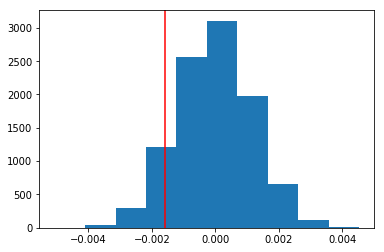

In [93]:
plt.hist(p_diffs);
plt.axvline(obs_diff, c='red')

In [94]:
p_diffs.mean()

-1.4749743660575229e-05

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [104]:
(obs_diff < p_diffs).mean()

0.90380000000000005

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<font color='STEELBLUE'>
The computed value was the p-value from the null simulation. 

Since we have a p-value bigger than the alpha $\alpha$ at error rate (0.05), we will fail to reject the null hypothesis.

Our P-Value is large (0.90) suggesting that we stay with the Null Hypothesis

This would mean p_new-p_old is less than 0, which suggest to stay with the old pages, as the change to new pages is not significant.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

convert_old = df2.query('group=="control" & converted==1')['user_id'].count()
convert_new = df2.query('group=="treatment" & converted==1')['user_id'].count()
n_old = n_old
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [42]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
(z_score, p_value)

(1.3109241984234394, 0.90505831275902449)

In [43]:
# Tells us how significant our z-score is
from scipy.stats import norm
norm.cdf(z_score)

0.90505831275902449

In [44]:
# Tells us what our critical value at 95% confidence is
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

** Z-Score ** = 1.310

** P-Value ** = 0.90

** Critical Value ** = 1.959
<font color='STEELBLUE'>

Since the Z-score doesn't exceed our critical value, we will fail to reject the Null Hypothesis and accept it.

Since we fail to reject the Null, this agrees indeed with point **j.** and **k.**

We conclude as well that our p-value is 0.90 as well after ensuring that our z-test is one-sided rather than two sided.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<font color='STEELBLUE'> 

Since each row is a conversion or no conversion, the type of regression would be a  logistic regression since we have the predictor values are only two possible outcomes either converted or not converted .. 0 or 1. 

Logistic regression is setting in a way where the linear model will predict the log odds rather than predicting the response itself.


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [96]:
ab_page = pd.get_dummies(df2['group'])
df2 = df2.join(ab_page)
df2.drop(['control'],axis=1,inplace=True)
df2.rename(columns={'treatment': 'ab_test'}, inplace=True)
df2.head()


,user_id,timestamp,group,landing_page,converted,ab_test
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [97]:
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_test']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 26 Feb 2018   Pseudo R-squ.:               8.077e-06
Time:                        16:56:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_test       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [98]:
np.exp(-0.0150)

0.98511193960306265

In [99]:
1/np.exp(-0.0150)

1.0151130646157189

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

<font color='STEELBLUE'>  
From the model summary we can interpert the following:
- The P-Value is equal to 0.190 which is  equal to the z-test output in point **j.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

<font color='STEELBLUE'>  
Our logistic model has the same NULL Hypothese compared in **Part II**. However, the resuls of p-value is different. Having a p-value of 0.190 compare to 0.90 which is again more than 5%, so we fail to reject the Null Hypothesis. 
</font>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<font color='STEELBLUE'>  

- It's a good idea to include other variable because group only won't tell whether a user would like to convert to a page or not, timestamp is continous and won't be practically significiant to whether a user might convert or not and nor the user_id.

- Adding other variable like the country in the upcoming section might be a good idea, only if it's related to the predictor variable (y), which can be checked later.

- disadvantages to adding other terms to my regression model **might** be:
    - Linearity
    - Collinearity (Multi-collinearity)
    - Non-constant Variance and Normally Distributed Errors




g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [100]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(2)

,country,timestamp,group,landing_page,converted,ab_test,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1


In [101]:
### Create the necessary dummy variables
countries = pd.get_dummies(df_new['country'])
df_new = df_new.join(countries)
df_new.drop(['CA'],axis=1,inplace=True)
df_new.head()

,country,timestamp,group,landing_page,converted,ab_test,intercept,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [102]:
### Fit Your Linear Model And Obtain the Results
logit_multi_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_test','UK','US']])
results = logit_multi_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 26 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        16:56:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_test       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [103]:
( 1/np.exp(-0.0149), np.exp(0.0506), np.exp(0.0408))

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

<font color='STEELBLUE'>  

From the results of the multi-linear regression we conclude the following:
- the p-value of UK and US are not significant since they are larger than 5% and same for ab_test when it was included with the new variables.

<a id='conclusions'></a>
## Conclusions

<font color='STEELBLUE'>  

- Based on the conclusions of Part II and Part III .. We will stay with the Null hypothesis of the old page being better than the new page.
- This was based on the hyopthesis of the difference of new_page - old_page being less than or equal to 0.
- Evidence for that in **Part II** is:
    - Observed difference was -0.0015 nearly a 0, however to determine if this is significant or not a 10K simulation of the differences between the conversions of new pages and old pages and the output was a p-value of 0.90 which is more than 5% so we will fail to reject the Null Hypothesis.
    - Then a built-in method (Z-Score) was used, and our Z-Score did not exceed the critical values, so again we failed to reject the Null Hypothesis, and it had the same P-Value  of 0.90.
 
- Evidence for that in ** Part III ** is:
    - Our logistic model had a p-value of 0.190 which is again more than 5%, so we fail to reject the Null Hypothesis. This make sense because we can't predict the conversion based only on group
    - Another model was tried which had the counteries of users, but still the results were not significant as the p-value was greater than alpha the error for all the variables added.
    
    ** Reason for different p-values in Part II and Part III **
    - The reason why we have different P-Value in Part II and Part III is because in our Hypothesis test, it was a one tailed of (p_new > p_old) while in part III Python computes P-Value using a not equal to which is why we have a different P-Value 